In [1]:
import os
from pandas import read_csv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib
import warnings
from  matplotlib.ticker import PercentFormatter

warnings.filterwarnings("ignore")
#work directory is where the I-O data are stored
work_dir = '/Users/xiaodanxu/Library/CloudStorage/GoogleDrive-arielinseu@gmail.com/My Drive/GEMS/BILD-AQ/'
os.chdir(work_dir)

plt.style.use('ggplot')
sns.set(font_scale=1.2)  # larger font

In [2]:
selected_state = 'CA'

direct_length = read_csv('data/Network/' + selected_state + '/NHTS_OD_desire_line_by_tract.csv')
routed_length = read_csv('data/Network/' + selected_state + '/nhts_thru_length_order_route_added.csv')

print(direct_length.columns)
print(routed_length.columns)

Index(['trip_indx', 'o_geoid', 'd_geoid', 'trpmiles', 'wtperfin', 'GEOID',
       'FID', 'MicrotypeID', 'thru_length', 'thru_length_ccst'],
      dtype='object')
Index(['thru_geoid', 'o_geoid', 'd_geoid', 'thru_length', 'distance',
       'trip_id', 'thru_fid', 'order', 'o_fid', 'd_fid', 'thru_length_ccst'],
      dtype='object')


In [3]:
direct_length_selected = direct_length[['trip_indx', 'o_geoid', 'd_geoid', 'GEOID', 'MicrotypeID',
                                        'wtperfin', 'thru_length']]
direct_length_selected.columns = ['trip_id', 'o_geoid', 'd_geoid', 'thru_geoid', 'MicrotypeID',
                                        'wtperfin', 'thru_length']
routed_length_selected = routed_length[['trip_id', 'o_geoid', 'd_geoid', 'thru_geoid', 'thru_length']]


In [4]:
through_length_compare = pd.merge(direct_length_selected, routed_length_selected,
                                  on = ['trip_id', 'o_geoid', 'd_geoid', 'thru_geoid'],
                                  how = 'outer')
through_length_compare = through_length_compare.fillna(0)
through_length_compare = through_length_compare.rename(columns={"thru_length_x": "direct length", 
                                                                "thru_length_y": "routed length"})
through_length_compare.loc[:, 'Geotype'] = through_length_compare.loc[:, 'MicrotypeID'].str.split('_').str[0] 
through_length_compare.loc[:, 'Microtype'] = through_length_compare.loc[:, 'MicrotypeID'].str.split('_').str[1]
through_length_compare.head(5)

,trip_id,o_geoid,d_geoid,thru_geoid,MicrotypeID,wtperfin,direct length,routed length,Geotype,Microtype
0,1,6111000902,6037123103,6037113212,A_2,892.495773,229.184496,0.000000,A,2
1,2,6037123103,6111000902,6037113212,A_2,892.495773,229.184496,0.000000,A,2
2,4375,6037113211,6037113301,6037113212,A_2,1296.717356,1092.965251,1512.846005,A,2
3,10677,6037231220,6111008402,6037113212,A_2,1682.349381,909.216610,0.000000,A,2
4,10686,6037231220,6111008402,6037113212,A_2,1652.486082,909.216610,0.000000,A,2


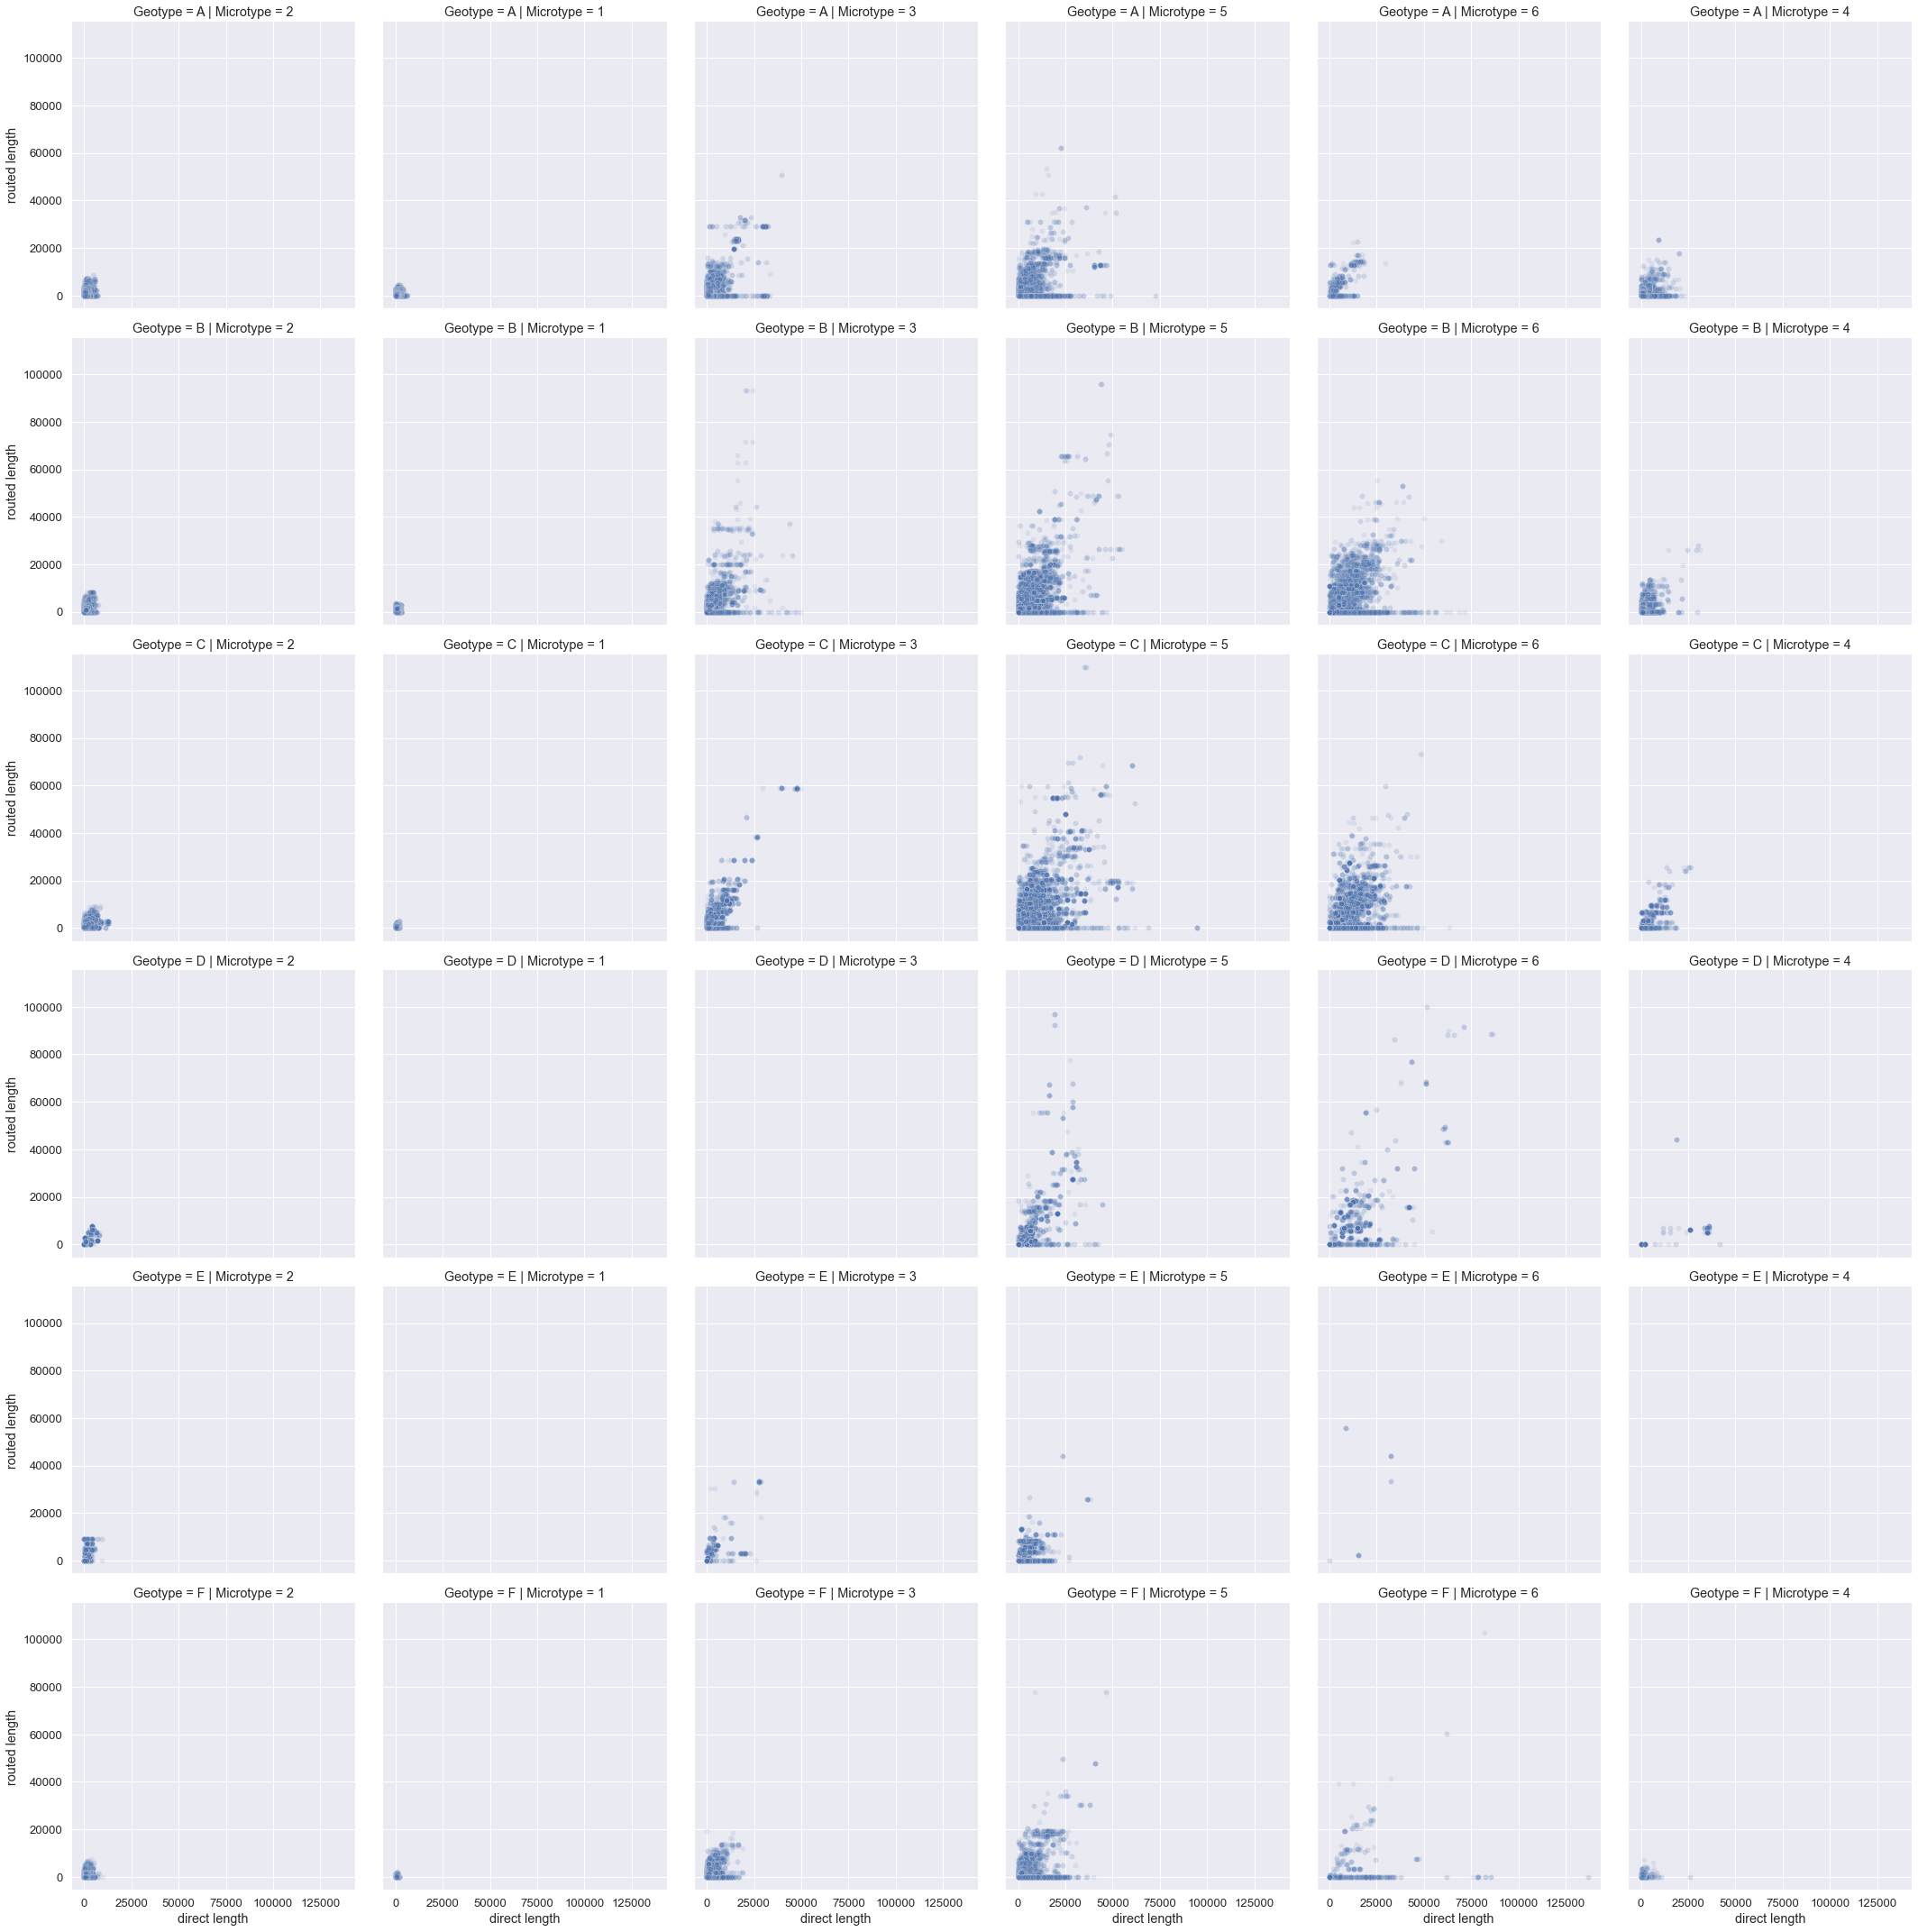

In [5]:
sns.relplot(
    data = through_length_compare, 
    x = "direct length", 
    y = "routed length",
    col = "Microtype", row = "Geotype", 
    kind="scatter", alpha = 0.1,
)

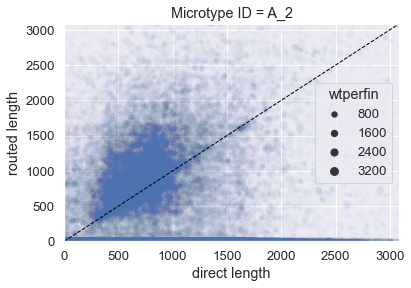

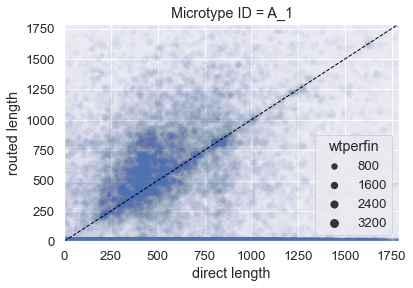

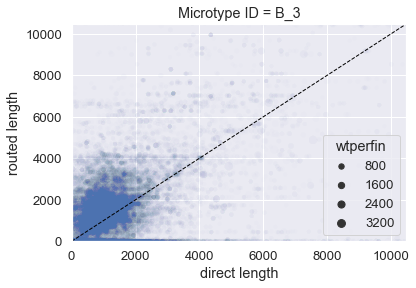

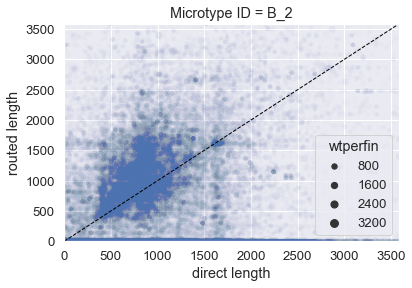

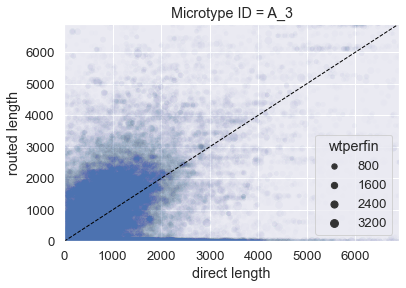

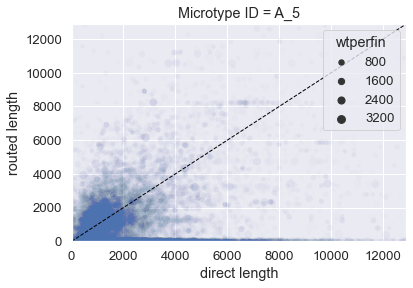

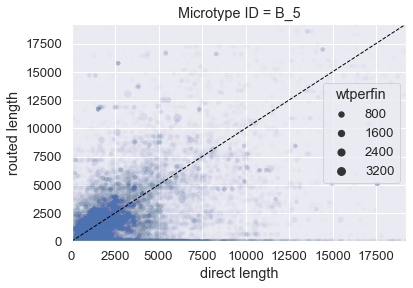

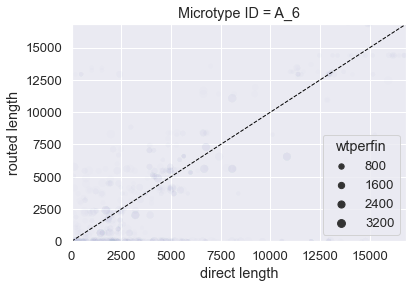

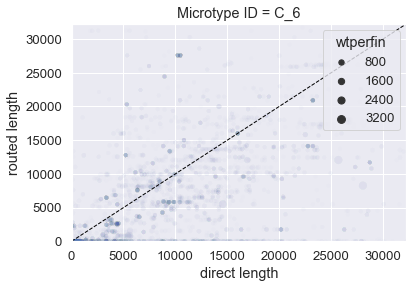

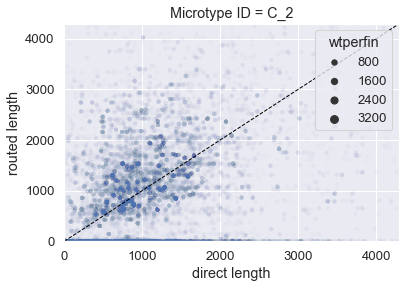

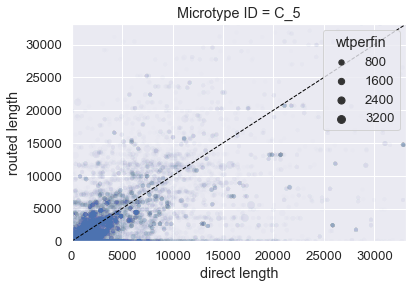

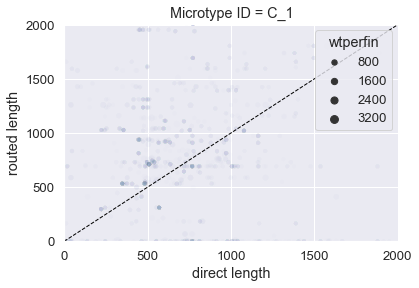

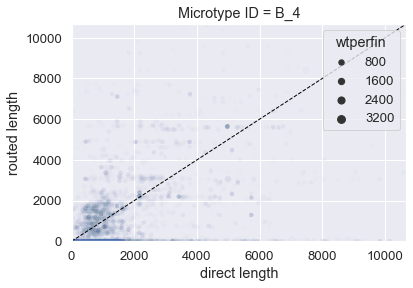

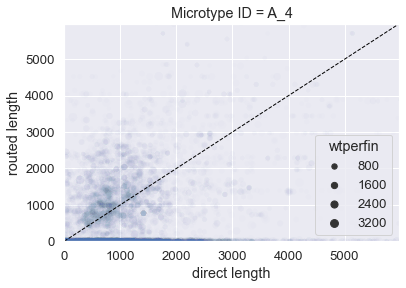

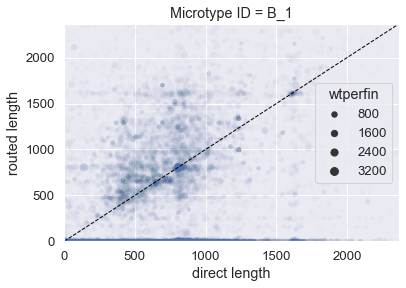

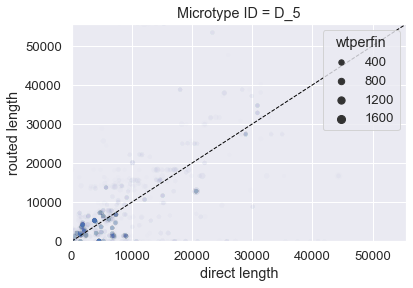

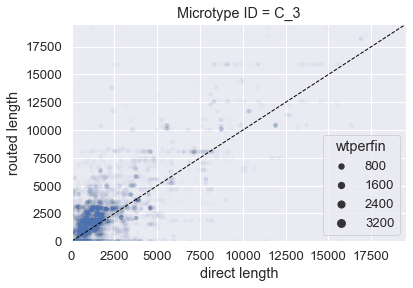

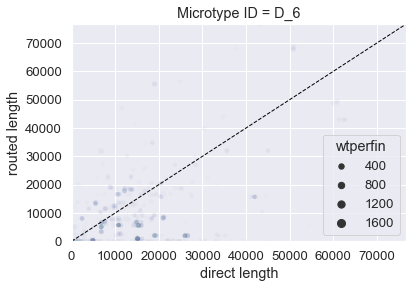

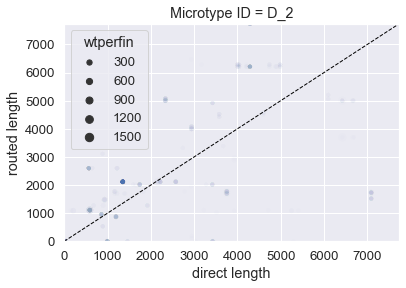

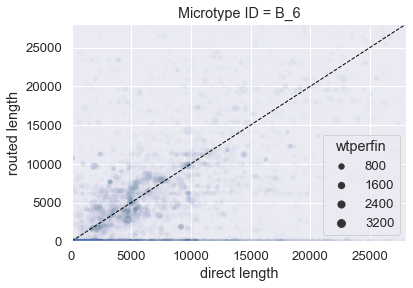

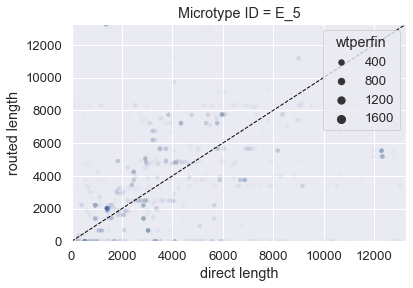

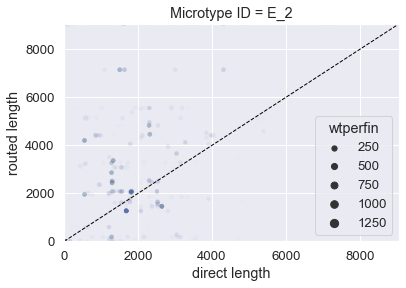

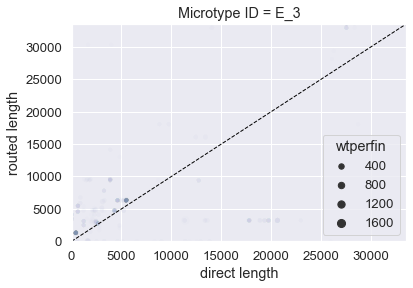

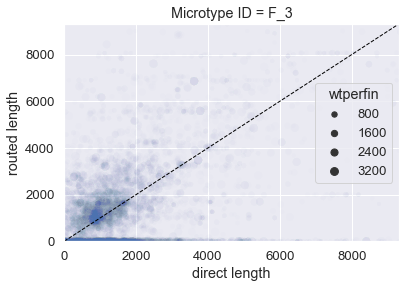

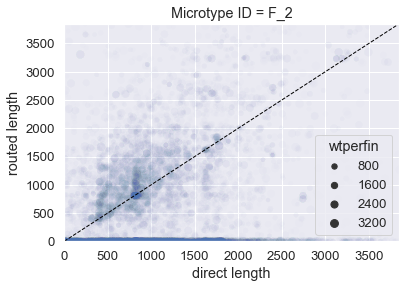

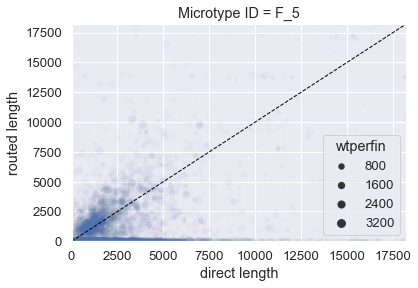

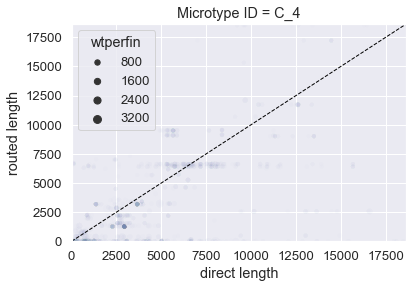

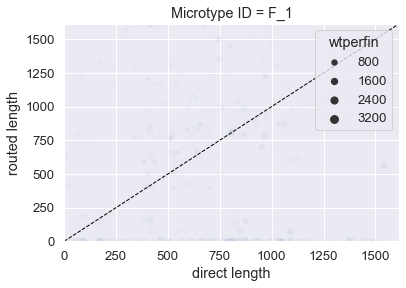

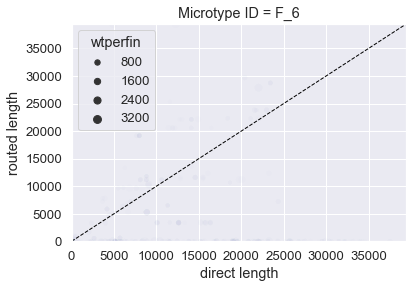

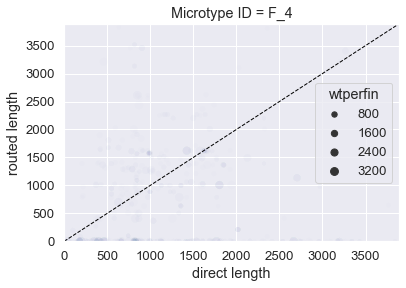

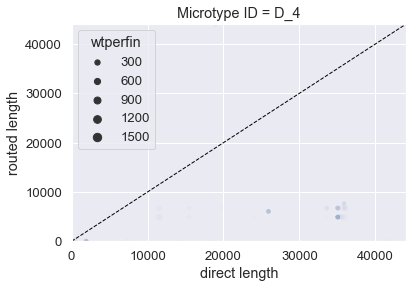

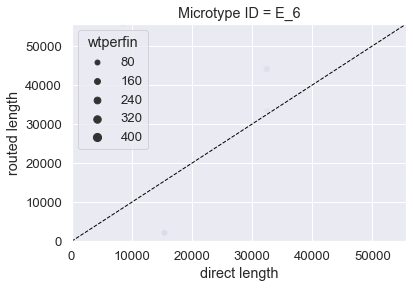

In [12]:
unique_micro_geotype = through_length_compare.MicrotypeID.unique()
through_length_compare = through_length_compare.loc[through_length_compare['MicrotypeID'] != 0]
for mt in unique_micro_geotype:
#     print(mt)
    data_to_plot = through_length_compare.loc[through_length_compare['MicrotypeID'] == mt]
    max_y = data_to_plot["routed length"].quantile(0.99)
    ax = sns.scatterplot(data = data_to_plot,
                    x ="direct length", 
                    y = "routed length", 
                    size = "wtperfin",
                   alpha = 0.01)
    plt.xlim([0, max_y])
    plt.ylim([0, max_y])
    ax.axline((1, 1), slope=1, linewidth=1, linestyle="--", color='black')
    plt.title('Microtype ID = ' + mt)
    plt.savefig('data/Plot/' + selected_state + '/through_length_compare_' + mt + '.png', 
                dpi = 200, bbox_inches = 'tight') 
    plt.show()
#     break

In [9]:
meter_to_mile = 0.000621371
through_length_compare.loc[:, 'total_mile_direct'] = through_length_compare.loc[:, 'direct length'] * \
through_length_compare.loc[:, 'wtperfin'] * meter_to_mile
through_length_compare.loc[:, 'total_mile_routed'] = through_length_compare.loc[:, 'routed length'] * \
through_length_compare.loc[:, 'wtperfin'] * meter_to_mile

total_distance_compare = \
through_length_compare.groupby(['thru_geoid', 'MicrotypeID'])[['total_mile_direct', 'total_mile_routed']].sum()
total_distance_compare = total_distance_compare.reset_index()
total_distance_compare.head(5)

,thru_geoid,MicrotypeID,total_mile_direct,total_mile_routed
0,6001400100,A_5,143516.425498,11659.036873
1,6001400200,A_2,30898.328325,15268.254038
2,6001400300,A_3,66446.935714,46485.421951
3,6001400400,A_1,40416.692905,15640.418477
4,6001400500,A_1,29418.740071,2935.990925


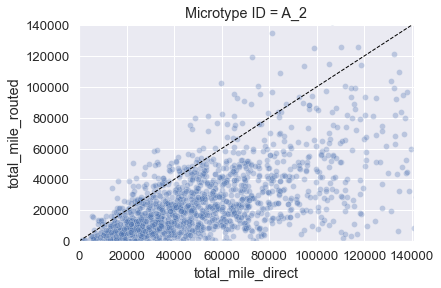

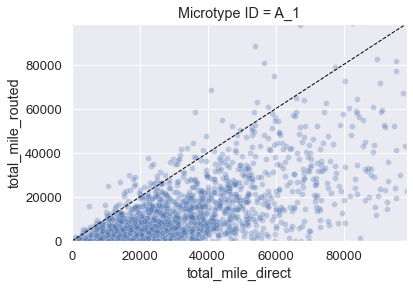

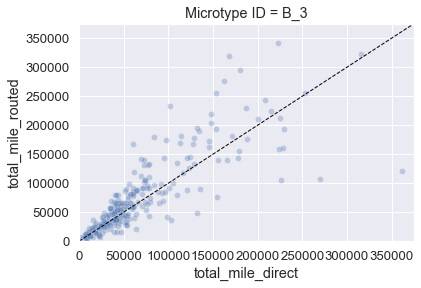

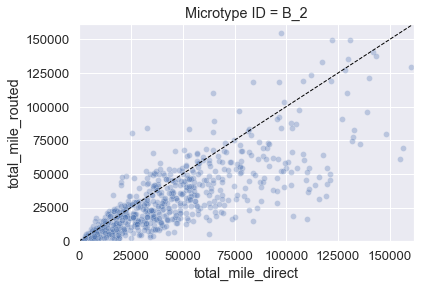

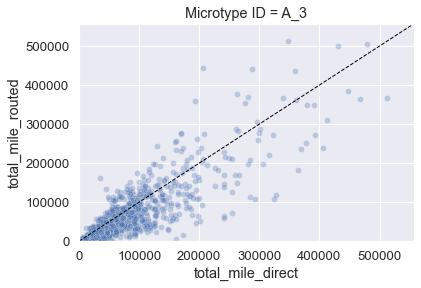

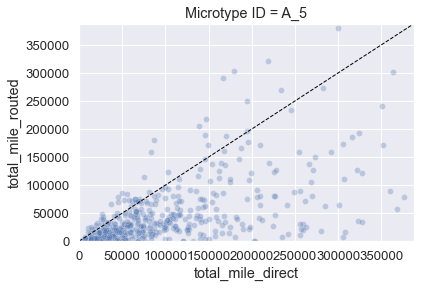

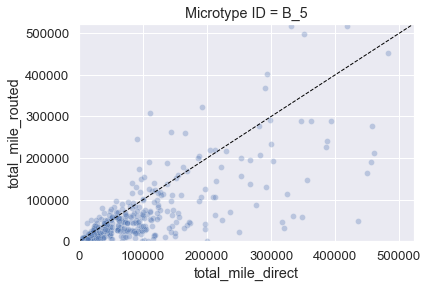

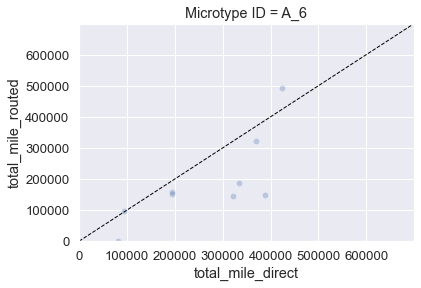

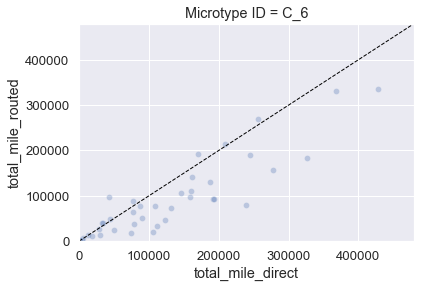

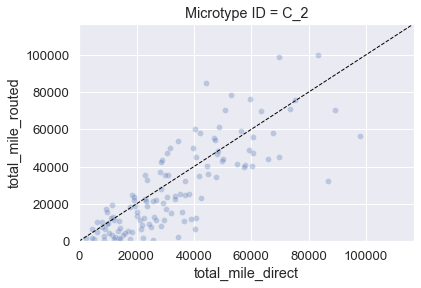

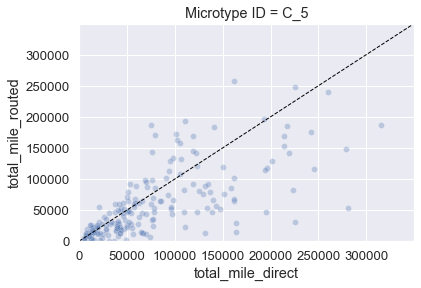

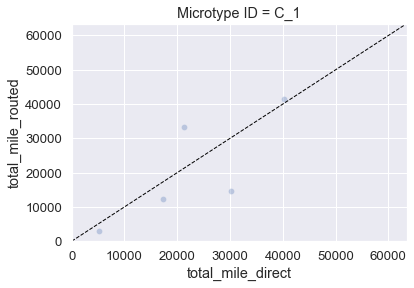

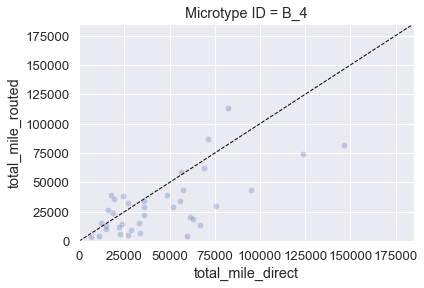

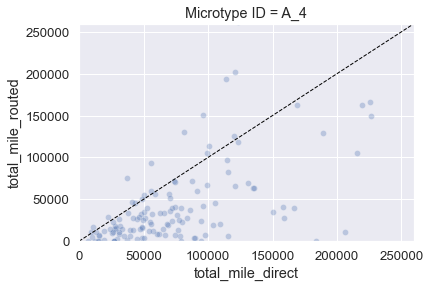

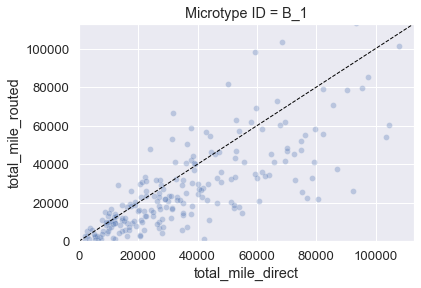

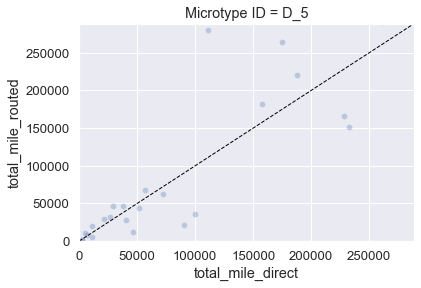

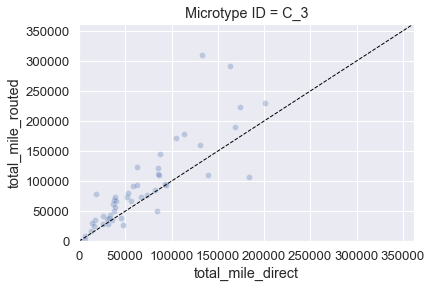

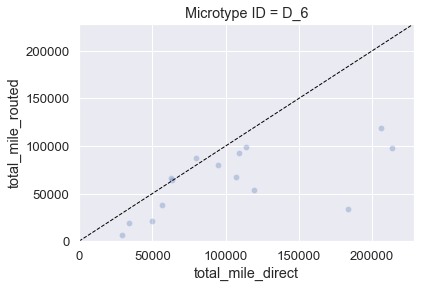

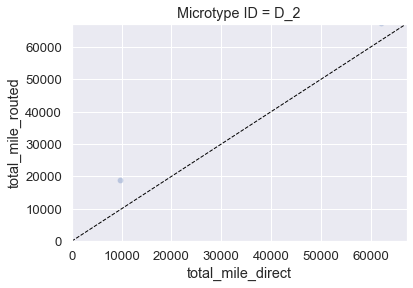

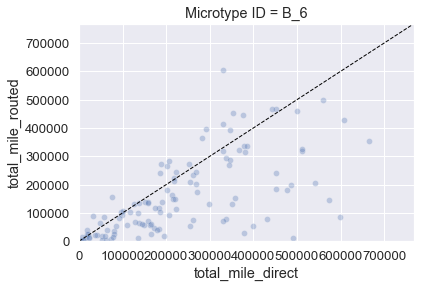

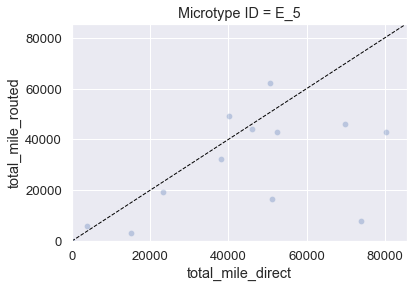

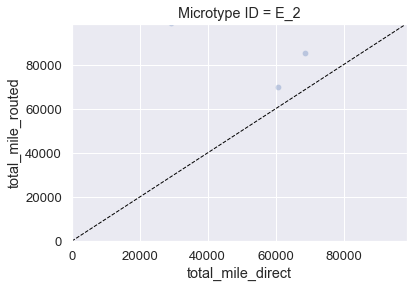

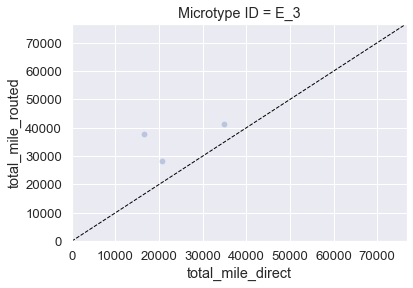

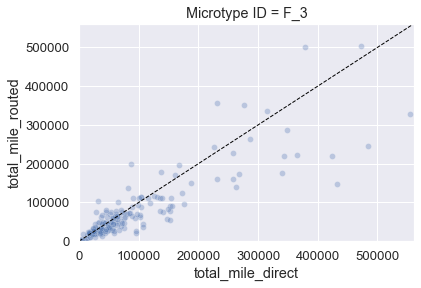

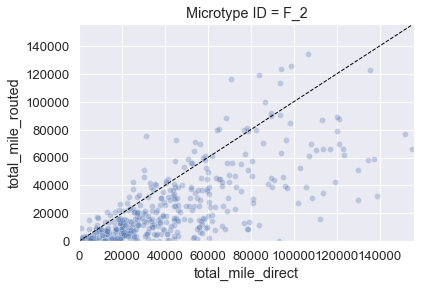

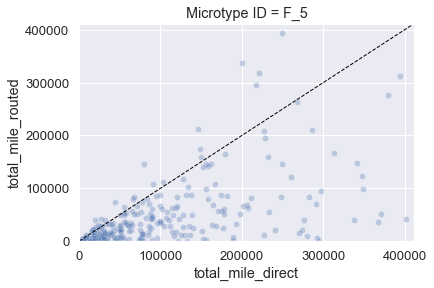

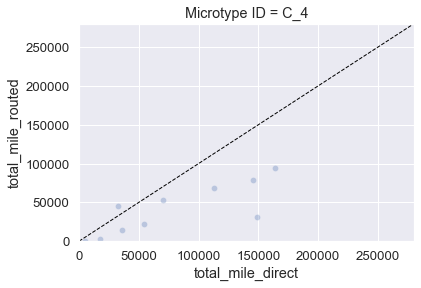

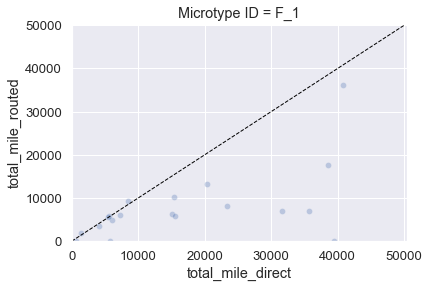

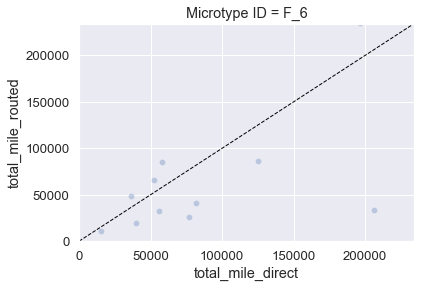

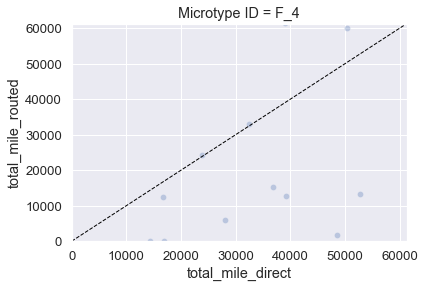

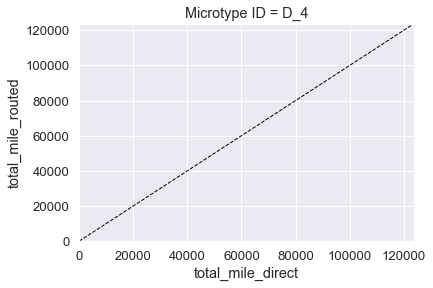

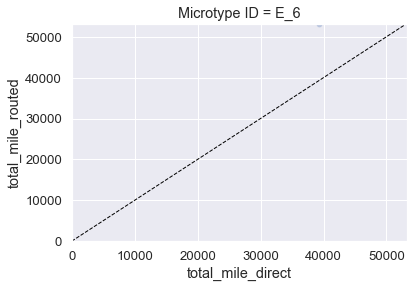

In [13]:
for mt in unique_micro_geotype:
#     print(mt)
    data_to_plot = total_distance_compare.loc[total_distance_compare['MicrotypeID'] == mt]
    max_y = data_to_plot["total_mile_routed"].quantile(0.99)
    ax = sns.scatterplot(data = data_to_plot,
                    x ="total_mile_direct", 
                    y = "total_mile_routed",
                   alpha = 0.3)
    plt.xlim([0, max_y])
    plt.ylim([0, max_y])
    ax.axline((1, 1), slope=1, linewidth=1, linestyle="--", color='black')
    plt.title('Microtype ID = ' + mt)
    plt.savefig('data/Plot/' + selected_state + '/total_distance_compare_' + mt + '.png', 
                dpi = 200, bbox_inches = 'tight') 
    plt.show()
#     break